### Mounting google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Files downloading and unzipping.

In [0]:
# import requests
# url='http://mmlab.ie.cuhk.edu.hk/projects/SRCNN/SRCNN_train.zip'
# r = requests.get(url,allow_redirects=True)
# f = open('/content/gdrive/My Drive/Colab Notebooks/Datasets/SRCNN_train.zip','wb')
# f.write(r.content)

In [0]:
# import zipfile
# with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Datasets/SRCNN_train.zip','r') as zip_ref:
#   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Datasets')

### Finally can read in the data

In [0]:
import glob

path = 'gdrive/My Drive/Colab Notebooks/Datasets/SRCNN/Train/images/*.bmp'
paths = glob.glob(path)

In [0]:
import cv2
import numpy as np

def process(path,factor):

  original_im = cv2.imread(path)
  h,w,_=original_im.shape
  new_h = int(h/factor)
  new_w = int(w/factor)
  im = cv2.resize(original_im,(new_w,new_h),interpolation=cv2.INTER_LINEAR)
  im = cv2.resize(original_im,(w,h),interpolation=cv2.INTER_LINEAR)
  return original_im,im
def into_matrix(paths):
  imgs_o = []
  imgs = []
  max_dim = 0
  for p in paths:
    img_o, img = process(p,2)
    imgs_o.append(img_o)
    imgs.append(img)
    d1,d2,_ =img_o.shape
    if d1 > max_dim or d2 > max_dim:
      if d1 > d2:
        max_dim = d1
      else:
        max_dim =d2
  imgs_o = [cv2.resize(im,(max_dim,max_dim),interpolation=cv2.INTER_LINEAR) for im in imgs_o]
  imgs = [cv2.resize(im,(max_dim,max_dim),interpolation=cv2.INTER_LINEAR) for im in imgs]
  return np.array(imgs_o),np.array(imgs)
img_o,img = into_matrix(paths)
print(img_o.shape,img.shape)

(91, 508, 508, 3) (91, 508, 508, 3)


(176, 197, 3)

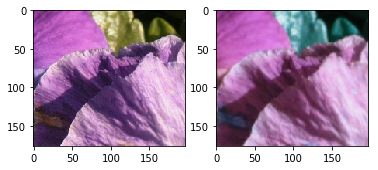

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image_i = 0

fig = plt.figure()
fig.add_subplot(1,2,1)
# original image
plt.imshow(mpimg.imread(paths[image_i]))
# degraded image
fig.add_subplot(1,2,2)
plt.imshow(dataset[image_i])
dataset[image_i].shape

### Let build a conv net

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv2DTranspose
from tensorflow.keras.optimizers import Adam

def make_model():
  SRCNN = Sequential()
  SRCNN.add(Conv2D(filters=128,kernel_size=(9,9),kernel_initializer='glorot_uniform',
                  activation='relu',padding='valid',use_bias=True,input_shape=(None,None,3)))
  SRCNN.add(Conv2D(filters=64,kernel_size=(3,3),kernel_initializer='glorot_uniform',
                  activation='relu',padding='same',use_bias=True))
  SRCNN.add(Conv2DTranspose(filters=3,kernel_size=(9,9),kernel_initializer='glorot_uniform',
                  activation='linear',padding='valid',use_bias=True))
  adam = Adam(lr=0.0003)
  SRCNN.compile(optimizer=adam,loss='mean_squared_error',metrics=['mean_squared_error'])
  return SRCNN
# model = make_model()
# model.summary()

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.model_selection import train_test_split
save_path = 'gdrive/My Drive/Colab saves/Image Super Resolution/Try1/'

# Defining checkpoints
logger = CSVLogger(save_path+'log.csv',append=True)
checkpt = ModelCheckpoint(save_path+'model.{epoch:02d}-{val_loss:.2f}.2.h5',
                          save_best_only=True,
                          monitor='val_loss',
                          period=10)


X_train,X_test,Y_train,Y_test = train_test_split(img_o/255,img/255)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)
model = make_model()
print(model.summary())
model.fit(X_train,Y_train,epochs=200,batch_size=10,verbose=2,
          validation_data=(X_test,Y_test),callbacks=[logger,checkpt])
model.save(save_path+'model1.h5')

# datagen = ImageDataGenerator(rescale = 1/255)
# train_generator = datagen.flow(X_train,Y_train)
# val_generator = datagen.flow(X_test,Y_test)
# model = make_model()
# model.fit_generator(train_generator,steps_per_epoch=len(X_train),epochs=10,
#                     validation_data=val_generator,validation_steps=len(X_test),
#                     verbose=1)
# model.save(save_path+'model1.h5')

(68, 508, 508, 3) (23, 508, 508, 3) (68, 508, 508, 3) (23, 508, 508, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 128)   31232     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, None, None, 3)     15555     
Total params: 120,579
Trainable params: 120,579
Non-trainable params: 0
_________________________________________________________________
None
Train on 68 samples, validate on 23 samples
Epoch 1/200
 - 5s - loss: 0.1045 - mean_squared_error: 0.1045 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 2/200
 - 5s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 3/200
 - 5s - loss: 0.0160 - mean_squared_err

In [0]:
a = np.array([[1,2,3],[1,2,3]])
len(a)

2

In [0]:
import numpy as np
temp = np.ones((32,12))
Y = np.zeros((1, 32, 12, 1), dtype=float)
Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
Y.shape

IndexError: ignored